In [68]:
import requests
import pandas as pd
import yfinance as yf
import talib
import numpy as np
from datetime import datetime
from tqdm import tqdm
from time import sleep

In [69]:
stocks_id = ["2330"]
stocks_df = {}
for stock_id in stocks_id:
    stock = yf.Ticker(f"{stock_id}.TW")
    df = stock.history(period="2y")
    stocks_df[stock_id] = df

In [70]:
# 為每一個股票加上技術指標: SMA, RSI, MACD
for stock_id in stocks_id:
    df = stocks_df[stock_id]
    df["SMA_5"] = talib.SMA(df["Close"], timeperiod=5)
    df["SMA_20"] = talib.SMA(df["Close"], timeperiod=20)
    df["RSI"] = talib.RSI(df["Close"], timeperiod=14)
    macd, macdsignal, macdhist = talib.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    df["MACD"] = macd
    df["MACD_SIGNAL"] = macdsignal
    df["MACD_HIST"] = macdhist
    df["KD_K"], df["KD_D"] = talib.STOCH(df["High"], df["Low"], df["Close"], fastk_period=9, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df["ATR"] = talib.ATR(df["High"], df["Low"], df["Close"], timeperiod=14)
    df["BOLL_UPPER"], df["BOLL_MIDDLE"], df["BOLL_LOWER"] = talib.BBANDS(df["Close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    # 因為macd是需要最多天數才能產生資料的，所以要從第一個有macd的row開始
    df = df[df["MACD"].notnull()]
    df.index = pd.DatetimeIndex(df.index)

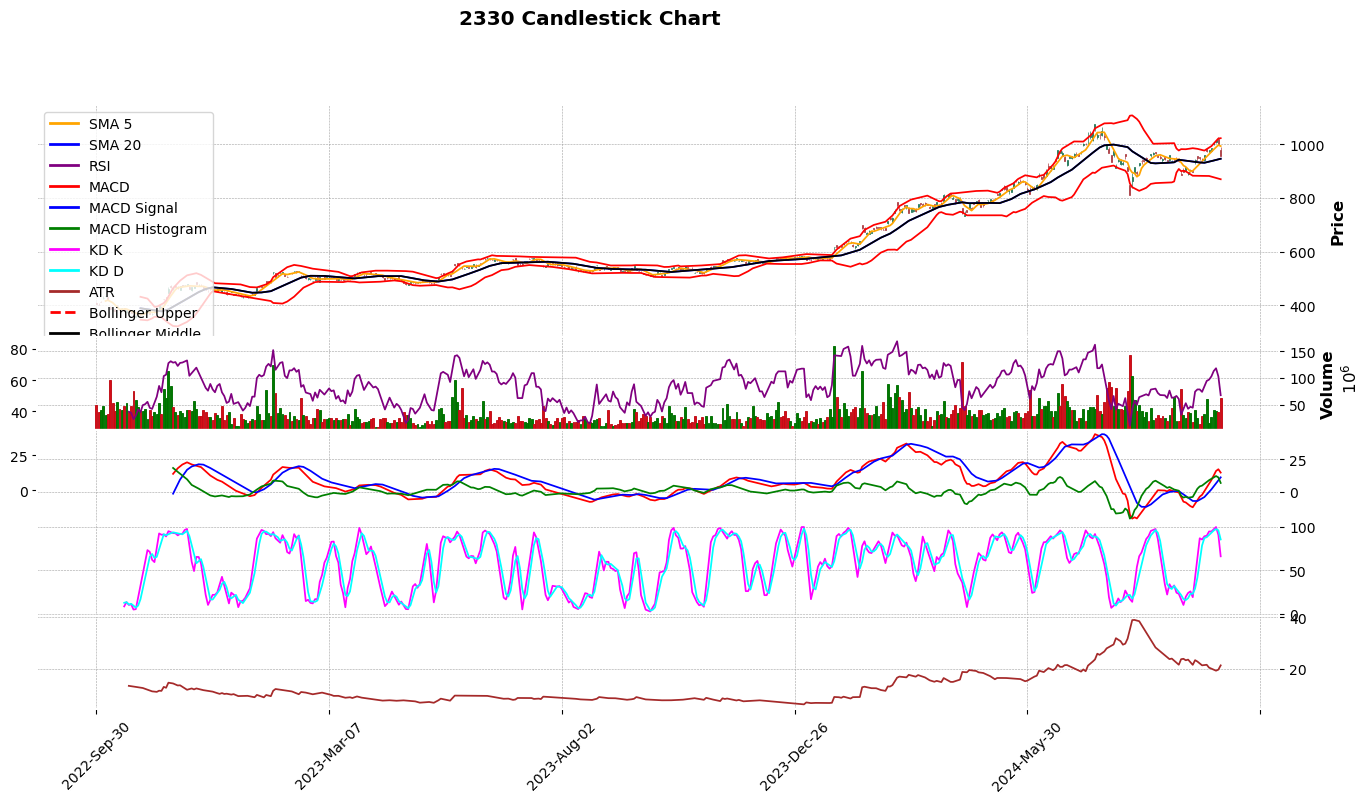

In [71]:
import mplfinance as mpf
import matplotlib.pyplot as plt

def plot_candlestick(df, stock_id):
    apds = [
        # 添加 SMA 5 和 SMA 20
        mpf.make_addplot(df["SMA_5"], color="orange"),
        mpf.make_addplot(df["SMA_20"], color="blue"),
        
        # 添加 RSI 指標（panel 1）
        mpf.make_addplot(df["RSI"], panel=1, color="purple"),
        
        # 添加 MACD 指標（panel 2）
        mpf.make_addplot(df["MACD"], panel=2, color="red"),
        mpf.make_addplot(df["MACD_SIGNAL"], panel=2, color="blue"),
        mpf.make_addplot(df["MACD_HIST"], panel=2, color="green"),
        
        # 添加 KD 指標（panel 3）
        mpf.make_addplot(df["KD_K"], panel=3, color="magenta"),
        mpf.make_addplot(df["KD_D"], panel=3, color="cyan"),
        
        # 添加 ATR（Average True Range）到主圖
        mpf.make_addplot(df["ATR"], panel=4, color="brown"),
        
        # 添加布林帶
        mpf.make_addplot(df["BOLL_UPPER"], color="red"),
        mpf.make_addplot(df["BOLL_MIDDLE"], color="black"),
        mpf.make_addplot(df["BOLL_LOWER"], color="red"),
    ]
    
    # 創建K線圖
    fig, axlist = mpf.plot(df, type='candle', style='charles', volume=True, addplot=apds,
                           title=f"{stock_id} Candlestick Chart", ylabel='Price', ylabel_lower='Volume',
                           figratio=(20, 10), figscale=1.5, returnfig=True)

    # 手動添加圖例
    ax = axlist[0]  # 取得主圖的axes
    handles = [
        plt.Line2D([0], [0], color="orange", label="SMA 5"),
        plt.Line2D([0], [0], color="blue", label="SMA 20"),
        plt.Line2D([0], [0], color="purple", label="RSI"),
        plt.Line2D([0], [0], color="red", label="MACD"),
        plt.Line2D([0], [0], color="blue", label="MACD Signal"),
        plt.Line2D([0], [0], color="green", label="MACD Histogram"),
        plt.Line2D([0], [0], color="magenta", label="KD K"),
        plt.Line2D([0], [0], color="cyan", label="KD D"),
        plt.Line2D([0], [0], color="brown", label="ATR"),
        plt.Line2D([0], [0], color="red", linestyle="--", label="Bollinger Upper"),
        plt.Line2D([0], [0], color="black", linestyle="-", label="Bollinger Middle"),
        plt.Line2D([0], [0], color="red", linestyle="--", label="Bollinger Lower")
    ]
    
    ax.legend(handles=handles)
    plt.show()

# 假設你有 stocks_id 和 stocks_df
for stock_id in stocks_id:
    plot_candlestick(stocks_df[stock_id], stock_id)


In [72]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)
df.columns, df.dtypes

(Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_20', 'RSI',
        'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'KD_K', 'KD_D', 'ATR', 'BOLL_UPPER',
        'BOLL_MIDDLE', 'BOLL_LOWER'],
       dtype='object'),
 Open           float64
 High           float64
 Low            float64
 Close          float64
 Volume           int64
 SMA_5          float64
 SMA_20         float64
 RSI            float64
 MACD           float64
 MACD_SIGNAL    float64
 MACD_HIST      float64
 KD_K           float64
 KD_D           float64
 ATR            float64
 BOLL_UPPER     float64
 BOLL_MIDDLE    float64
 BOLL_LOWER     float64
 dtype: object)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Linear Regression Avg MSE: 263.8086295600563
XGBoost Avg MSE: 3590.2693239233895
Decision Tree Avg MSE: 3266.648464278833
Random Forest Avg MSE: 3449.9325243416447
Linear Regression Avg MAE: 10.901933289409916
XGBoost Avg MAE: 37.15827049255371
Decision Tree Avg MAE: 37.984981765747065
Random Forest Avg MAE: 37.01617585830689
Linear Regression Avg MAPE: 1.6089703594295437%
XGBoost Avg MAPE: 4.855971526037605%
Decision Tree Avg MAPE: 5.004563618822425%
Random Forest Avg MAPE: 4.814093782217742%


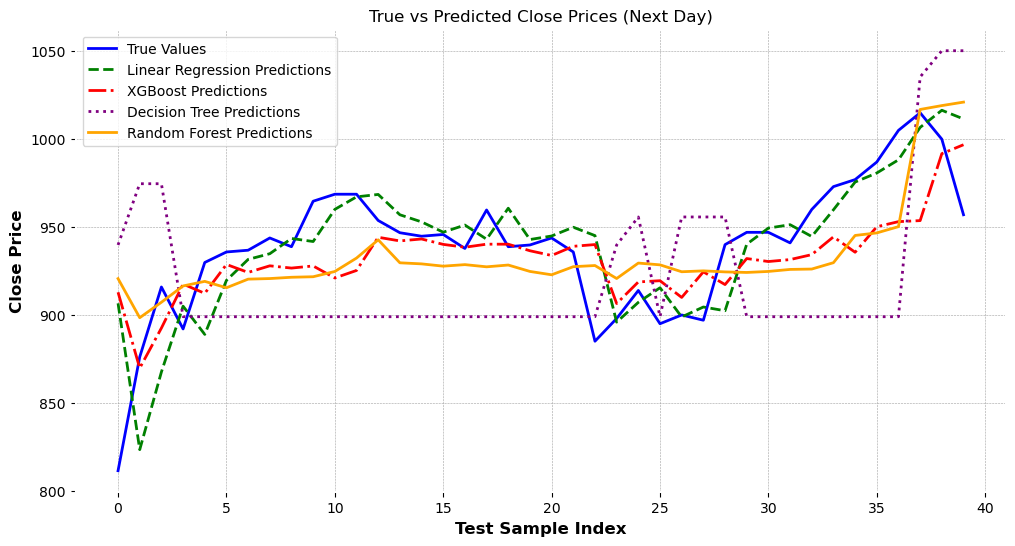

In [73]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

# 把 'Close' 移動一行作為目標變量
df['Close_next_day'] = df['Close'].shift(-1)

# 移除最後一行因為沒有'Close_next_day'值
df = df[:-1]

# 特徵與目標
X = df.drop('Close_next_day', axis=1)  # 所有的特徵
y = df['Close_next_day']  # 目標變數：隔天的Close

# 建立時間序列分割 (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=10)

# 定義 XGBoost 的參數網格
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

# 使用 GridSearchCV 進行 XGBoost 模型的超參數調整
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# 使用 GridSearchCV 與 TimeSeriesSplit 進行交叉驗證
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)

# 進行訓練
grid_search.fit(X, y)

# 獲取最佳參數
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# 使用最佳參數進行模型訓練與預測
best_xg_reg = grid_search.best_estimator_

# 初始化誤差列表
mse_lr_list, mse_xgb_list, mse_dt_list, mse_rf_list = [], [], [], []
mae_lr_list, mae_xgb_list, mae_dt_list, mae_rf_list = [], [], [], []
mape_lr_list, mape_xgb_list, mape_dt_list, mape_rf_list = [], [], [], []

# 使用時間序列交叉驗證進行多次訓練和測試
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 線性回歸模型
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)

    # 使用最佳的 XGBoost 模型
    best_xg_reg.fit(X_train, y_train)
    y_pred_xgb = best_xg_reg.predict(X_test)

    # 決策樹模型
    dt = DecisionTreeRegressor()
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)

    # 隨機森林模型
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    # 計算MSE, MAE, MAPE 並加入列表
    mse_lr_list.append(mean_squared_error(y_test, y_pred_lr))
    mse_xgb_list.append(mean_squared_error(y_test, y_pred_xgb))
    mse_dt_list.append(mean_squared_error(y_test, y_pred_dt))
    mse_rf_list.append(mean_squared_error(y_test, y_pred_rf))
    
    mae_lr_list.append(mean_absolute_error(y_test, y_pred_lr))
    mae_xgb_list.append(mean_absolute_error(y_test, y_pred_xgb))
    mae_dt_list.append(mean_absolute_error(y_test, y_pred_dt))
    mae_rf_list.append(mean_absolute_error(y_test, y_pred_rf))
    
    mape_lr_list.append(np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100)
    mape_xgb_list.append(np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100)
    mape_dt_list.append(np.mean(np.abs((y_test - y_pred_dt) / y_test)) * 100)
    mape_rf_list.append(np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100)

# 計算平均誤差
print(f'Linear Regression Avg MSE: {np.mean(mse_lr_list)}')
print(f'XGBoost Avg MSE: {np.mean(mse_xgb_list)}')
print(f'Decision Tree Avg MSE: {np.mean(mse_dt_list)}')
print(f'Random Forest Avg MSE: {np.mean(mse_rf_list)}')

print(f'Linear Regression Avg MAE: {np.mean(mae_lr_list)}')
print(f'XGBoost Avg MAE: {np.mean(mae_xgb_list)}')
print(f'Decision Tree Avg MAE: {np.mean(mae_dt_list)}')
print(f'Random Forest Avg MAE: {np.mean(mae_rf_list)}')

print(f'Linear Regression Avg MAPE: {np.mean(mape_lr_list)}%')
print(f'XGBoost Avg MAPE: {np.mean(mape_xgb_list)}%')
print(f'Decision Tree Avg MAPE: {np.mean(mape_dt_list)}%')
print(f'Random Forest Avg MAPE: {np.mean(mape_rf_list)}%')

# 畫圖比較真實值與預測值，全部用線表示（最後一次分割的結果）
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='True Values', color='blue')
plt.plot(y_pred_lr, label='Linear Regression Predictions', color='green', linestyle='--')
plt.plot(y_pred_xgb, label='XGBoost Predictions', color='red', linestyle='-.')
plt.plot(y_pred_dt, label='Decision Tree Predictions', color='purple', linestyle=':')
plt.plot(y_pred_rf, label='Random Forest Predictions', color='orange', linestyle='-')
plt.title('True vs Predicted Close Prices (Next Day)')
plt.xlabel('Test Sample Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()
